<h1>London-Paris-compare</h1>

<h1>Introduction and Business Problem</h1>

London and Paris are two of the most ancient city in the world. This project is aim to try to analysis the two cities, more specifically I aimed to analysis how the cities can be separated to several section(cluster) with similar shops and facilities. By doing so, I believe we can have betting understanding of the two cities.

The Reason for choosing London and Paris is because both cities have a lot of data available to the public and make it very easy to collect data for both of the cities.

<h1>Data Description</h1>

<h2>London</h2>

I get the data from https://en.wikipedia.org/wiki/List_of_London_boroughs

The dataframe contain data of London consist:
1. Borough : Name of Borough
2. Latitude : Latitude
3. Longitude : Longitude

<h2>Paris</h2>

I get the data from https://en.wikipedia.org/wiki/Arrondissements_of_Paris and from https://www.data.gouv.fr/fr/datasets/r/e88c6fda-1d09-42a0-a069-606d3259114e.

I preprocess the data into a cvs file already.

The dataframe contain data of Paris consist:
1. District : Name of District
2. Latitude : Latitude
3. Longitude : Longitude

<h2>Foursquare API Data</h2>

I will get data from foursquare API to analysis each distrinct in London and in Paris 

In [1]:
import requests
import pandas as pd
import numpy as np
import urllib.request
from geopy.geocoders import Nominatim
import folium
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans

In [2]:
CLIENT_ID = '32MVT5TKDCXDFDDR0DUTZTUKTE1J02ZOCSTRSFZ4V3RTV5VN' # your Foursquare ID
CLIENT_SECRET = 'POM4TH0RJ3U0NAEHV4VLSNGS2RGS2Q0BMWYXPF10AVXANF1E' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [3]:
## URL to extract City neighbourhood information
urlL = "https://en.wikipedia.org/wiki/List_of_London_boroughs"
pageLondon = urllib.request.urlopen(urlL)
wikitablesL = pd.read_html(urlL,  attrs={"class":"wikitable"})
dfL0 = wikitablesL[0]
dfL1 = wikitablesL[1]

In [4]:
dfL0=dfL0.rename(columns={'Population (2019 est)[1]':'Population(2019 est)',}).drop(columns=['Nr. in map'])
dfL1=dfL1.drop(columns=['Nr. inmap'])
dfl=pd.concat([dfL0,dfL1]).reset_index().drop(columns=['index'])
dfl=dfl.drop(columns=['Inner','Status','Local authority','Political control','Headquarters','Area (sq mi)','Population(2019 est)'])
dfl['Co-ordinates'][0]='51.5607°N 0.1557°E'
lat_list=[51.5607]
log_list=[0.1557]
for i in range(1,dfl.shape[0]):
    index=dfl['Co-ordinates'][i].find('/')
    dfl['Co-ordinates'][i]=dfl['Co-ordinates'][i][index+1:]
    coord=dfl['Co-ordinates'][i].split(' ')
    lat=float(coord[1][:8].encode('utf-8').decode('utf-8-sig'))
    if coord[2][-1]=='W':
        flag=-1
    else:
        flag=1
    log=flag*float(coord[2][:6])
    lat_list.append(lat)
    log_list.append(log)
dfl['Latitude']=lat_list
dfl['Longitude']=log_list
dfl.drop(columns=['Co-ordinates'],inplace=True)
dfl.loc[0,'Borough']='Barking and Dagenham'
dfl.loc[9,'Borough']='Greenwich'
dfl.loc[11,'Borough']='Hammersmith and Fulham'
dfl.head()

,Borough,Latitude,Longitude
0,Barking and Dagenham,51.5607,0.1557
1,Barnet,51.6252,-0.1517
2,Bexley,51.4549,0.1505
3,Brent,51.5588,-0.2817
4,Bromley,51.4039,0.0198


In [5]:
dfp=pd.read_csv(R"C:\Users\lautszchun\Desktop\projects_and_resources\coursera-data-science\London-Paris-camparison\Paris-data.csv")
dfp.head()

,postal_code,district,nom_dept,Latitude,Longitude
0,75001,Louvre,PARIS,48.862630,2.336293
1,75002,Bourse,PARIS,48.867903,2.344107
2,75003,Temple,PARIS,48.863054,2.359361
3,75004,Hotel-de-Ville,PARIS,48.854228,2.357362
4,75005,Pantheon,PARIS,48.844509,2.349859


In [6]:
address = 'London'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
london_latitude = location.latitude
london_longitude = location.longitude

map_london = folium.Map(location=[london_latitude, london_longitude], zoom_start=10)

for lat, lng, borough in zip(dfl['Latitude'],dfl['Longitude'],dfl['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

In [7]:
address = 'Paris'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
paris_latitude = location.latitude
paris_longitude = location.longitude

map_paris = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12)

for lat, lng, borough in zip(dfp['Latitude'],dfp['Longitude'],dfp['district']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [9]:
London_venues=getNearbyVenues(dfl['Borough'],dfl['Latitude'],dfl['Longitude'])

In [10]:
Paris_venues = getNearbyVenues(dfp['district'],dfp['Latitude'],dfp['Longitude'])

In [20]:
# one hot encoding
london_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = London_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

# one hot encoding
paris_onehot = pd.get_dummies(Paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = Paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

<h2> Showing the top 5 venue in London</h2>

<AxesSubplot:ylabel='Venue Category'>

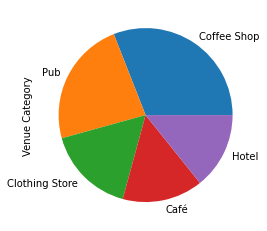

In [21]:
ld_venue_count=London_venues['Venue Category'].value_counts()
ld_venue_count[:5].plot(kind = 'pie')

<h2> Showing the top 5 venue in Paris</h2>

<AxesSubplot:ylabel='Venue Category'>

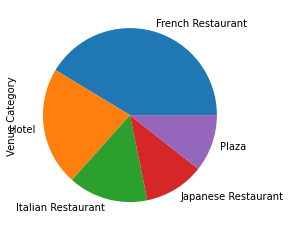

In [22]:
pr_venue_count=Paris_venues['Venue Category'].value_counts()
pr_venue_count[:5].plot(kind = 'pie')

In [23]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)

    return row_categories_sorted.index.values[0:num_top_venues]

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
london_venues_sorted = pd.DataFrame(columns=columns)
london_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    london_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    
    
paris_venues_sorted = pd.DataFrame(columns=columns)
paris_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    paris_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

In [38]:
two_city=pd.concat([london_grouped,paris_grouped],ignore_index=True)
two_city=two_city.fillna(0)

In [40]:
k=3
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)
london_kmeans = KMeans(n_clusters=k, random_state=0).fit(london_grouped_clustering)

paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)
paris_kmeans = KMeans(n_clusters=k, random_state=0).fit(paris_grouped_clustering)

two_city_clustering = two_city.drop('Neighborhood',1)
two_city_kmeans=KMeans(n_clusters=k, random_state=0).fit(two_city_clustering)

In [46]:
two_city_kmeans.labels_[0:33]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0])

In [47]:
two_city_kmeans.labels_[34:]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2])

In [53]:
london_venues_sorted.insert(0, 'Cluster Labels', two_city_kmeans.labels_[0:33])

In [57]:
london_merged = dfl

london_merged = london_merged.join(london_venues_sorted.set_index('Neighborhood'), on='Borough')

london_merged.head() 

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,51.5607,0.1557,0,Gym / Fitness Center,Pool,Bus Station,Supermarket,Park,Martial Arts School,Golf Course,Outdoors & Recreation,New American Restaurant,Nightclub
1,Barnet,51.6252,-0.1517,1,Café,Bus Stop,Business Service,African Restaurant,Outlet Store,Nightclub,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Event Space
2,Bexley,51.4549,0.1505,0,Clothing Store,Pub,Coffee Shop,Fast Food Restaurant,Pharmacy,Supermarket,Shopping Mall,Furniture / Home Store,Hotel,Discount Store
3,Brent,51.5588,-0.2817,0,Hotel,Coffee Shop,Bar,Clothing Store,Sporting Goods Shop,Grocery Store,Indian Restaurant,Burger Joint,Italian Restaurant,Restaurant
4,Bromley,51.4039,0.0198,0,Clothing Store,Coffee Shop,Bar,Gym / Fitness Center,Burger Joint,Pizza Place,Donut Shop,Supermarket,Sushi Restaurant,Bookstore


In [59]:
paris_venues_sorted.insert(0, 'Cluster Labels', two_city_kmeans.labels_[33:])

paris_merged = dfp

paris_merged = paris_merged.join(paris_venues_sorted.set_index('Neighborhood'), on='district')

paris_merged.head() 

,postal_code,district,nom_dept,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75001,Louvre,PARIS,48.862630,2.336293,2,French Restaurant,Japanese Restaurant,Hotel,Plaza,Italian Restaurant,Art Museum,Restaurant,Theater,Historic Site,Garden
1,75002,Bourse,PARIS,48.867903,2.344107,2,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Italian Restaurant,Plaza,Salad Place,Hotel,Creperie,Coffee Shop
2,75003,Temple,PARIS,48.863054,2.359361,2,French Restaurant,Japanese Restaurant,Coffee Shop,Art Gallery,Gourmet Shop,Italian Restaurant,Wine Bar,Cocktail Bar,Bakery,Sandwich Place
3,75004,Hotel-de-Ville,PARIS,48.854228,2.357362,2,French Restaurant,Ice Cream Shop,Clothing Store,Hotel,Italian Restaurant,Plaza,Garden,Wine Bar,Park,Pastry Shop
4,75005,Pantheon,PARIS,48.844509,2.349859,2,French Restaurant,Hotel,Italian Restaurant,Plaza,Bar,Bakery,Pub,Café,Coffee Shop,Vietnamese Restaurant


<h1>Showing the Clusters of London</h1>

In [60]:
# create map
london_map_clusters = folium.Map(location=[london_latitude, london_longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Borough'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(london_map_clusters)
       
london_map_clusters

<h1>Showing the Clusters of Paris</h1>

In [61]:
# create map
paris_map_clusters = folium.Map(location=[paris_latitude, paris_longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['district'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(paris_map_clusters)
       
paris_map_clusters

In [62]:
(london_merged.loc[london_merged['Cluster Labels'] == 0])

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,51.5607,0.1557,0,Gym / Fitness Center,Pool,Bus Station,Supermarket,Park,Martial Arts School,Golf Course,Outdoors & Recreation,New American Restaurant,Nightclub
2,Bexley,51.4549,0.1505,0,Clothing Store,Pub,Coffee Shop,Fast Food Restaurant,Pharmacy,Supermarket,Shopping Mall,Furniture / Home Store,Hotel,Discount Store
3,Brent,51.5588,-0.2817,0,Hotel,Coffee Shop,Bar,Clothing Store,Sporting Goods Shop,Grocery Store,Indian Restaurant,Burger Joint,Italian Restaurant,Restaurant
4,Bromley,51.4039,0.0198,0,Clothing Store,Coffee Shop,Bar,Gym / Fitness Center,Burger Joint,Pizza Place,Donut Shop,Supermarket,Sushi Restaurant,Bookstore
5,Camden,51.5290,-0.1255,0,Coffee Shop,Hotel,Café,Pub,Breakfast Spot,Train Station,Deli / Bodega,Pizza Place,Modern European Restaurant,Italian Restaurant
6,Croydon,51.3714,-0.0977,0,Pub,Coffee Shop,Korean Restaurant,Asian Restaurant,Portuguese Restaurant,Mediterranean Restaurant,Clothing Store,Brewery,Strip Club,Burger Joint
7,Ealing,51.5130,-0.3089,0,Coffee Shop,Clothing Store,Park,Pub,Bakery,Italian Restaurant,Pizza Place,Burger Joint,Hotel,Bookstore
8,Enfield,51.6538,-0.0799,0,Coffee Shop,Clothing Store,Pub,Supermarket,Department Store,Pharmacy,Bookstore,Optical Shop,Café,Gift Shop
9,Greenwich,51.4892,0.0648,0,Coffee Shop,Fast Food Restaurant,Pub,Clothing Store,Supermarket,Grocery Store,Hotel,Plaza,Pharmacy,Sandwich Place
10,Hackney,51.5450,-0.0553,0,Pub,Coffee Shop,Café,Brewery,Cocktail Bar,Bakery,Clothing Store,Grocery Store,Park,Modern European Restaurant


In [63]:
(london_merged.loc[london_merged['Cluster Labels'] == 1])

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Barnet,51.6252,-0.1517,1,Café,Bus Stop,Business Service,African Restaurant,Outlet Store,Nightclub,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Event Space
16,Hounslow,51.4746,-0.3680,1,Bed & Breakfast,Café,Metro Station,Park,Outlet Store,New American Restaurant,Nightclub,Okonomiyaki Restaurant,Optical Shop,Organic Grocery


In [64]:
(london_merged.loc[london_merged['Cluster Labels'] == 2])

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Newham,51.5077,0.0469,2,Hotel,Airport Service,Sandwich Place,Currency Exchange,Chinese Restaurant,Airport,Light Rail Station,Pharmacy,Rafting,Italian Restaurant


In [65]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0]

,postal_code,district,nom_dept,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,75012,Reuilly,PARIS,48.835156,2.419807,0,Zoo Exhibit,Zoo,Supermarket,Monument / Landmark,Bistro,Pedestrian Plaza,New American Restaurant,Noodle House,Okonomiyaki Restaurant,Optical Shop


In [66]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1]

,postal_code,district,nom_dept,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


In [67]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2]

,postal_code,district,nom_dept,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,75001,Louvre,PARIS,48.862630,2.336293,2,French Restaurant,Japanese Restaurant,Hotel,Plaza,Italian Restaurant,Art Museum,Restaurant,Theater,Historic Site,Garden
1,75002,Bourse,PARIS,48.867903,2.344107,2,French Restaurant,Cocktail Bar,Wine Bar,Bakery,Italian Restaurant,Plaza,Salad Place,Hotel,Creperie,Coffee Shop
2,75003,Temple,PARIS,48.863054,2.359361,2,French Restaurant,Japanese Restaurant,Coffee Shop,Art Gallery,Gourmet Shop,Italian Restaurant,Wine Bar,Cocktail Bar,Bakery,Sandwich Place
3,75004,Hotel-de-Ville,PARIS,48.854228,2.357362,2,French Restaurant,Ice Cream Shop,Clothing Store,Hotel,Italian Restaurant,Plaza,Garden,Wine Bar,Park,Pastry Shop
4,75005,Pantheon,PARIS,48.844509,2.349859,2,French Restaurant,Hotel,Italian Restaurant,Plaza,Bar,Bakery,Pub,Café,Coffee Shop,Vietnamese Restaurant
5,75006,Luxembourg,PARIS,48.848968,2.332671,2,Chocolate Shop,French Restaurant,Bakery,Restaurant,Pastry Shop,Fountain,Theater,Italian Restaurant,Plaza,Bistro
6,75007,Palais-Bourbon,PARIS,48.856083,2.312439,2,Hotel,French Restaurant,Italian Restaurant,Café,Plaza,Bistro,History Museum,Coffee Shop,Cocktail Bar,Japanese Restaurant
7,75008,Elysse,PARIS,48.872527,2.312583,2,French Restaurant,Hotel,Spa,Art Gallery,Corsican Restaurant,Italian Restaurant,Bar,Sporting Goods Shop,Park,Grocery Store
8,75009,Opera,PARIS,48.876896,2.337460,2,French Restaurant,Hotel,Bistro,Japanese Restaurant,Cocktail Bar,Restaurant,Lounge,Wine Bar,Bakery,Bar
9,75010,Entrepot,PARIS,48.876029,2.361113,2,French Restaurant,Bistro,Hotel,Café,Coffee Shop,Indian Restaurant,Asian Restaurant,Pizza Place,Japanese Restaurant,Seafood Restaurant


<h1>Final Conculsion</h1>

In the two cities, they are not quite similar.
But Newham in London is quite the same with the majority of Paris.
And Reuilly	in Paris is quite the same with the majority of London.
Barnet and Hounslow in London is the outliers among the two cities.